In [19]:
import math
import  numpy as np
import matplotlib.pyplot as plt

In [20]:
class Value:
    def __init__(self, data, _children=(), op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward= lambda: None
        self._prev = set(_children)
        self.label = label
        self.op= op
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data , (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward= _backward
    
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    


    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward= _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)
        topo    

        self.grad = 1.0
        for node in reversed(topo):
                node._backward()



 


In [21]:
from graphviz import Digraph 
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
   
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            dot.node(name= uid + n.op, label=n.op)
            dot.edge(uid + n.op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)) , str(id(n2)) + n2.op)
    
    return dot

In [22]:
#inputs    
x_1 = Value(2.0, label='x_1')    
x_2 = Value(0.0, label='x_2')

#weights
w_1 = Value(-3.0, label='w_1')
w_2 = Value(1.0, label='w_2')

#bias of neuron
b = Value(6.88137358, label='b')

xw1 = x_1 * w_1;  xw1.label = 'xw1'
xw2 = x_2 * w_2;  xw2.label = 'xw2'
xw = xw1 + xw2; xw.label = 'xw'
n = xw + b; n.label = 'n'
o = n.tanh(); o.label = 'output'




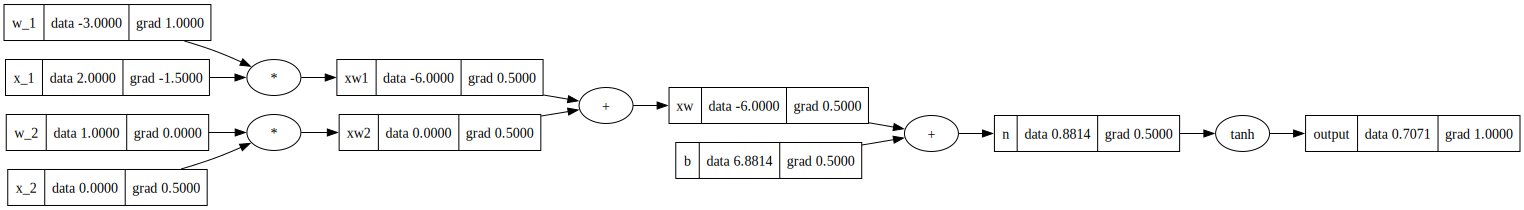

In [23]:

o.backward()
draw_dot(o)

In [24]:
import torch
x_1 =torch.Tensor([2.0]).double()     ; x_1.requires_grad = True
x_2 =torch.Tensor([0.0]).double()       ; x_2.requires_grad = True
w_1 = torch.Tensor([-3.0]).double()     ; w_1.requires_grad = True
w_2 = torch.Tensor([1.0]).double()      ; w_2.requires_grad = True
b = torch.Tensor([6.88137358]).double() ; b.requires_grad = True
n= x_1 * w_1 + x_2 * w_2 + b 
o= torch.tanh(n)

print(o.data.item())
o.backward()

print('x_2', x_2.grad.item())
print('w_2', w_2.grad.item())
print('x_1', x_1.grad.item())
print('w_2', w_1.grad.item())

0.7071066904050358
x_2 0.5000001283844369
w_2 0.0
x_1 -1.5000003851533106
w_2 1.0000002567688737
